In [1]:


import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.autograd import Variable

from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
import os
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("zabir110islam/salary-data-prediction")
print("Path to dataset files:", path)

print("Contenu du dossier :", os.listdir(path))

csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)

df = pd.read_csv(csv_path)
print("Fichier chargé :", csv_path)
df.head()

100%|██████████| 378/378 [00:00<00:00, 996kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/zabir110islam/salary-data-prediction/versions/1
Contenu du dossier : ['Salary_Data.csv']
Fichier chargé : /root/.cache/kagglehub/datasets/zabir110islam/salary-data-prediction/versions/1/Salary_Data.csv


,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


Paramètres

In [3]:
seq_len = 24
n_seq = 2
hidden_dim = 24
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
train_steps = 5000

gan_args = (batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim)

Preprocessing

In [4]:

def preprocess(data, seq_len):
    ori_data = data[::-1]
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)

    temp_data = []
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])

    return data

stock_data = preprocess(df.values, seq_len)

Fonction de construction de réseau

In [5]:

def make_net(n_layers, hidden_units, output_units, net_type='GRU'):
    layers = []
    for i in range(n_layers):
        if net_type == 'GRU':
            layers.append(nn.GRU(hidden_units if i > 0 else hidden_units,
                                 hidden_units,
                                 batch_first=True))
        else:
            layers.append(nn.LSTM(hidden_units if i > 0 else hidden_units,
                                  hidden_units,
                                  batch_first=True))

    layers.append(nn.Linear(hidden_units, output_units))
    layers.append(nn.Sigmoid())

    return layers

Définition des modèles - Generator

In [48]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, n_seq):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_seq = n_seq

        self.rnn1 = nn.GRU(n_seq, hidden_dim, batch_first=True)
        self.rnn2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.rnn3 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.rnn3(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim, net_type='GRU'):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.net_type = net_type

        self.rnn1 = nn.GRU(hidden_dim, hidden_dim, batch_first=True) if net_type == 'GRU' else nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.rnn2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True) if net_type == 'GRU' else nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.rnn3 = nn.GRU(hidden_dim, hidden_dim, batch_first=True) if net_type == 'GRU' else nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.rnn3(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

 Recovery

In [8]:

class Recovery(nn.Module):
    def __init__(self, hidden_dim, n_seq):
        super(Recovery, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_seq = n_seq

        self.rnn1 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.rnn2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.rnn3 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_seq)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.rnn3(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

Embedder

In [34]:


class Embedder(nn.Module):
    def __init__(self, hidden_dim, n_seq):
        super(Embedder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_seq = n_seq

        self.rnn1 = nn.GRU(n_seq, hidden_dim, batch_first=True)
        self.rnn2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.rnn3 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.rnn3(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

Supervisor

In [10]:
class Supervisor(nn.Module):
    def __init__(self, hidden_dim):
        super(Supervisor, self).__init__()
        self.hidden_dim = hidden_dim

        self.rnn1 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.rnn2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

 Classe TimeGAN - Initialisation

In [49]:
class TimeGAN():
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        self.seq_len = seq_len
        self.batch_size, self.lr, self.beta_1, self.beta_2, self.noise_dim, self.data_dim, self.layers_dim = model_parameters
        self.n_seq = n_seq
        self.hidden_dim = hidden_dim
        self.gamma = gamma

        self.device = device
        self.define_gan()

    def define_gan(self):
        self.generator_aux = Generator(self.hidden_dim, self.n_seq).to(self.device)
        self.supervisor = Supervisor(self.hidden_dim).to(self.device)
        self.discriminator = Discriminator(self.hidden_dim).to(self.device)
        self.recovery = Recovery(self.hidden_dim, self.n_seq).to(self.device)
        self.embedder = Embedder(self.hidden_dim, self.n_seq).to(self.device)

        # Loss functions
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()

Méthodes d'entraînement - Autoencoder

In [50]:

class TimeGAN(TimeGAN):
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        super().__init__(model_parameters, hidden_dim, seq_len, n_seq, gamma)

    def train_autoencoder(self, x, optimizer):
        optimizer.zero_grad()

        # Forward pass
        h = self.embedder(x)
        x_tilde = self.recovery(h)

        # Calculate loss
        embedding_loss_t0 = self.mse_loss(x, x_tilde)
        e_loss_0 = 10 * torch.sqrt(embedding_loss_t0)

        # Backward pass
        e_loss_0.backward()
        optimizer.step()

        return torch.sqrt(embedding_loss_t0)

In [51]:
def get_batch_data(self, data, n_windows):
    data_tensor = torch.FloatTensor(np.array(data)).to(self.device)
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    while True:
        for batch in dataloader:
            yield batch[0]

def get_batch_noise(self):
    while True:
        noise = torch.FloatTensor(self.batch_size, self.seq_len, self.n_seq).uniform_(0, 1).to(self.device)
        yield noise

def sample(self, n_samples):
    self.generator_aux.eval()
    self.supervisor.eval()
    self.recovery.eval()

    steps = n_samples // self.batch_size + 1
    data = []

    with torch.no_grad():
        for _ in trange(steps, desc='Synthetic data generation'):
            z = torch.FloatTensor(self.batch_size, self.seq_len, self.n_seq).uniform_(0, 1).to(self.device)
            e_hat = self.generator_aux(z)
            h_hat = self.supervisor(e_hat)
            x_hat = self.recovery(h_hat)
            data.append(x_hat.cpu().numpy())

    self.generator_aux.train()
    self.supervisor.train()
    self.recovery.train()

    return np.vstack(data)

# Ajouter les méthodes à la classe TimeGAN
TimeGAN.get_batch_data = get_batch_data
TimeGAN.get_batch_noise = get_batch_noise
TimeGAN.sample = sample

In [52]:
# Ajouter toutes les méthodes d'entraînement à TimeGAN

def train_autoencoder(self, x, optimizer):
    optimizer.zero_grad()

    # Forward pass
    h = self.embedder(x)
    x_tilde = self.recovery(h)

    # Calculate loss
    embedding_loss_t0 = self.mse_loss(x, x_tilde)
    e_loss_0 = 10 * torch.sqrt(embedding_loss_t0)

    # Backward pass
    e_loss_0.backward()
    optimizer.step()

    return torch.sqrt(embedding_loss_t0)

def train_supervisor(self, x, optimizer):
    optimizer.zero_grad()

    # Forward pass
    h = self.embedder(x)
    h_hat_supervised = self.supervisor(h)

    # Calculate loss
    g_loss_s = self.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    # Backward pass
    g_loss_s.backward()
    optimizer.step()

    return g_loss_s

def train_embedder(self, x, optimizer):
    optimizer.zero_grad()

    # Forward pass
    h = self.embedder(x)
    h_hat_supervised = self.supervisor(h)
    generator_loss_supervised = self.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_tilde = self.recovery(h)
    embedding_loss_t0 = self.mse_loss(x, x_tilde)
    e_loss = 10 * torch.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    # Backward pass
    e_loss.backward()
    optimizer.step()

    return torch.sqrt(embedding_loss_t0)

def discriminator_loss(self, x, z):
    # Real data
    h = self.embedder(x)
    y_real = self.discriminator(h)
    discriminator_loss_real = self.bce_loss(y_real, torch.ones_like(y_real))

    # Fake data from supervisor
    e_hat = self.generator_aux(z)
    h_hat = self.supervisor(e_hat)
    y_fake = self.discriminator(h_hat)
    discriminator_loss_fake = self.bce_loss(y_fake, torch.zeros_like(y_fake))

    # Fake data from generator
    y_fake_e = self.discriminator(e_hat)
    discriminator_loss_fake_e = self.bce_loss(y_fake_e, torch.zeros_like(y_fake_e))

    return (discriminator_loss_real +
            discriminator_loss_fake +
            self.gamma * discriminator_loss_fake_e)

@staticmethod
def calc_generator_moments_loss(y_true, y_pred):
    y_true_mean = torch.mean(y_true, dim=0)
    y_true_var = torch.var(y_true, dim=0)
    y_pred_mean = torch.mean(y_pred, dim=0)
    y_pred_var = torch.var(y_pred, dim=0)

    g_loss_mean = torch.mean(torch.abs(y_true_mean - y_pred_mean))
    g_loss_var = torch.mean(torch.abs(torch.sqrt(y_true_var + 1e-6) - torch.sqrt(y_pred_var + 1e-6)))

    return g_loss_mean + g_loss_var

def train_generator(self, x, z, optimizer):
    optimizer.zero_grad()

    # Adversarial loss (supervised)
    e_hat = self.generator_aux(z)
    h_hat = self.supervisor(e_hat)
    y_fake = self.discriminator(h_hat)
    generator_loss_unsupervised = self.bce_loss(y_fake, torch.ones_like(y_fake))

    # Adversarial loss (unsupervised)
    y_fake_e = self.discriminator(e_hat)
    generator_loss_unsupervised_e = self.bce_loss(y_fake_e, torch.ones_like(y_fake_e))

    # Supervised loss
    h = self.embedder(x)
    h_hat_supervised = self.supervisor(h)
    generator_loss_supervised = self.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    # Moment loss
    x_hat = self.recovery(h_hat)
    generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)

    # Total generator loss
    generator_loss = (generator_loss_unsupervised +
                     generator_loss_unsupervised_e +
                     100 * torch.sqrt(generator_loss_supervised) +
                     100 * generator_moment_loss)

    # Backward pass
    generator_loss.backward()
    optimizer.step()

    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

def train_discriminator(self, x, z, optimizer):
    optimizer.zero_grad()

    # Calculate discriminator loss
    d_loss = self.discriminator_loss(x, z)

    # Backward pass
    d_loss.backward()
    optimizer.step()

    return d_loss

# Ajouter toutes les méthodes à la classe TimeGAN
TimeGAN.train_autoencoder = train_autoencoder
TimeGAN.train_supervisor = train_supervisor
TimeGAN.train_embedder = train_embedder
TimeGAN.discriminator_loss = discriminator_loss
TimeGAN.calc_generator_moments_loss = calc_generator_moments_loss
TimeGAN.train_generator = train_generator
TimeGAN.train_discriminator = train_discriminator

Méthodes d'entraînement - Supervisor

In [41]:
def train_supervisor(self, x, optimizer):
        optimizer.zero_grad()

        # Forward pass
        h = self.embedder(x)
        h_hat_supervised = self.supervisor(h)

        # Calculate loss
        g_loss_s = self.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        # Backward pass
        g_loss_s.backward()
        optimizer.step()

        return g_loss_s

Méthodes d'entraînement - Embedder

In [15]:

def train_embedder(self, x, optimizer):
        optimizer.zero_grad()

        # Forward pass
        h = self.embedder(x)
        h_hat_supervised = self.supervisor(h)
        generator_loss_supervised = self.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = self.recovery(h)
        embedding_loss_t0 = self.mse_loss(x, x_tilde)
        e_loss = 10 * torch.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        # Backward pass
        e_loss.backward()
        optimizer.step()

        return torch.sqrt(embedding_loss_t0)

Discriminator Loss

In [16]:
def train_embedder(self, x, optimizer):
        optimizer.zero_grad()

        h = self.embedder(x)
        h_hat_supervised = self.supervisor(h)
        generator_loss_supervised = self.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = self.recovery(h)
        embedding_loss_t0 = self.mse_loss(x, x_tilde)
        e_loss = 10 * torch.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        e_loss.backward()
        optimizer.step()

        return torch.sqrt(embedding_loss_t0)

Generator Moments Loss

In [20]:
@staticmethod
def calc_generator_moments_loss(y_true, y_pred):
    y_true_mean = torch.mean(y_true, dim=0)
    y_true_var = torch.var(y_true, dim=0)
    y_pred_mean = torch.mean(y_pred, dim=0)
    y_pred_var = torch.var(y_pred, dim=0)

    g_loss_mean = torch.mean(torch.abs(y_true_mean - y_pred_mean))
    g_loss_var = torch.mean(torch.abs(torch.sqrt(y_true_var + 1e-6) - torch.sqrt(y_pred_var + 1e-6)))

    return g_loss_mean + g_loss_var

Train Generator

In [21]:
def train_generator(self, x, z, optimizer):
        optimizer.zero_grad()

        # Adversarial loss (supervised)
        e_hat = self.generator_aux(z)
        h_hat = self.supervisor(e_hat)
        y_fake = self.discriminator(h_hat)
        generator_loss_unsupervised = self.bce_loss(y_fake, torch.ones_like(y_fake))

        # Adversarial loss (unsupervised)
        y_fake_e = self.discriminator(e_hat)
        generator_loss_unsupervised_e = self.bce_loss(y_fake_e, torch.ones_like(y_fake_e))

        # Supervised loss
        h = self.embedder(x)
        h_hat_supervised = self.supervisor(h)
        generator_loss_supervised = self.mse_loss(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        # Moment loss
        x_hat = self.recovery(h_hat)
        generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)

        # Total generator loss
        generator_loss = (generator_loss_unsupervised +
                         generator_loss_unsupervised_e +
                         100 * torch.sqrt(generator_loss_supervised) +
                         100 * generator_moment_loss)

        # Backward pass
        generator_loss.backward()
        optimizer.step()

        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

Train Discriminator

In [22]:
def train_discriminator(self, x, z, optimizer):
        optimizer.zero_grad()

        # Calculate discriminator loss
        d_loss = self.discriminator_loss(x, z)

        # Backward pass
        d_loss.backward()
        optimizer.step()

        return d_loss

Data Loaders

In [23]:
def get_batch_data(self, data, n_windows):
        data_tensor = torch.FloatTensor(np.array(data)).to(self.device)
        dataset = TensorDataset(data_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        while True:
            for batch in dataloader:
                yield batch[0]

def get_batch_noise(self):
    while True:
        noise = torch.FloatTensor(self.batch_size, self.seq_len, self.n_seq).uniform_(0, 1).to(self.device)
        yield noise

Sample Generator

In [24]:
def sample(self, n_samples):
        self.generator_aux.eval()
        self.supervisor.eval()
        self.recovery.eval()

        steps = n_samples // self.batch_size + 1
        data = []

        with torch.no_grad():
            for _ in trange(steps, desc='Synthetic data generation'):
                z = torch.FloatTensor(self.batch_size, self.seq_len, self.n_seq).uniform_(0, 1).to(self.device)
                e_hat = self.generator_aux(z)
                h_hat = self.supervisor(e_hat)
                x_hat = self.recovery(h_hat)
                data.append(x_hat.cpu().numpy())

        self.generator_aux.train()
        self.supervisor.train()
        self.recovery.train()

        return np.vstack(data)

Instanciation du modèle

In [53]:

synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)

Training - Autoencoder

In [54]:
# Training - Embedding network training
autoencoder_params = list(synth.embedder.parameters()) + list(synth.recovery.parameters())
autoencoder_opt = optim.Adam(autoencoder_params, lr=learning_rate)

data_generator = synth.get_batch_data(stock_data, n_windows=len(stock_data))

for _ in tqdm(range(train_steps), desc='Embedding network training'):
    X_ = next(data_generator)
    step_e_loss_t0 = synth.train_autoencoder(X_, autoencoder_opt)

Embedding network training: 100%|██████████| 5000/5000 [00:29<00:00, 167.97it/s]


In [55]:

supervisor_params = list(synth.supervisor.parameters()) + list(synth.generator_aux.parameters())
supervisor_opt = optim.Adam(supervisor_params, lr=learning_rate)

for _ in tqdm(range(train_steps), desc='Supervised network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    step_g_loss_s = synth.train_supervisor(X_, supervisor_opt)

Supervised network training: 100%|██████████| 5000/5000 [00:28<00:00, 175.22it/s]


Training - Joint Networks

In [56]:
generator_params = list(synth.generator_aux.parameters()) + list(synth.supervisor.parameters())
generator_opt = optim.Adam(generator_params, lr=learning_rate)

embedder_params = list(synth.embedder.parameters()) + list(synth.recovery.parameters())
embedder_opt = optim.Adam(embedder_params, lr=learning_rate)

discriminator_opt = optim.Adam(synth.discriminator.parameters(), lr=learning_rate)

step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0

for _ in tqdm(range(train_steps), desc='Joint networks training'):
    # Train the generator (k times as often as the discriminator)
    # Here k=2
    for _ in range(2):
        X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
        Z_ = next(synth.get_batch_noise())

        # Train the generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = synth.train_generator(X_, Z_, generator_opt)

        # Train the embedder
        step_e_loss_t0 = synth.train_embedder(X_, embedder_opt)

    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    Z_ = next(synth.get_batch_noise())
    step_d_loss = synth.discriminator_loss(X_, Z_)

    if step_d_loss > 0.15:
        step_d_loss = synth.train_discriminator(X_, Z_, discriminator_opt)

Joint networks training: 100%|██████████| 5000/5000 [06:17<00:00, 13.24it/s]


Analyzing - Échantillonnage

In [58]:

sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synth_data = synth.sample(len(stock_data))
synthetic_sample = np.asarray(synth_data)[idx]

# For the purpose of comparison we need the data to be 2-Dimensional
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1, seq_len)

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00, 220.40it/s]


PCA et t-SNE

In [60]:
n_components = 2
pca = PCA(n_components=n_components)

# Calculer une perplexity appropriée (doit être < n_samples)
n_samples = len(stock_data_reduced)
perplexity_value = min(30, n_samples - 1)  # Par défaut 30, mais ajusté si nécessaire

tsne = TSNE(n_components=n_components, n_iter=300, perplexity=perplexity_value)

# The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualisation - PCA et t-SNE

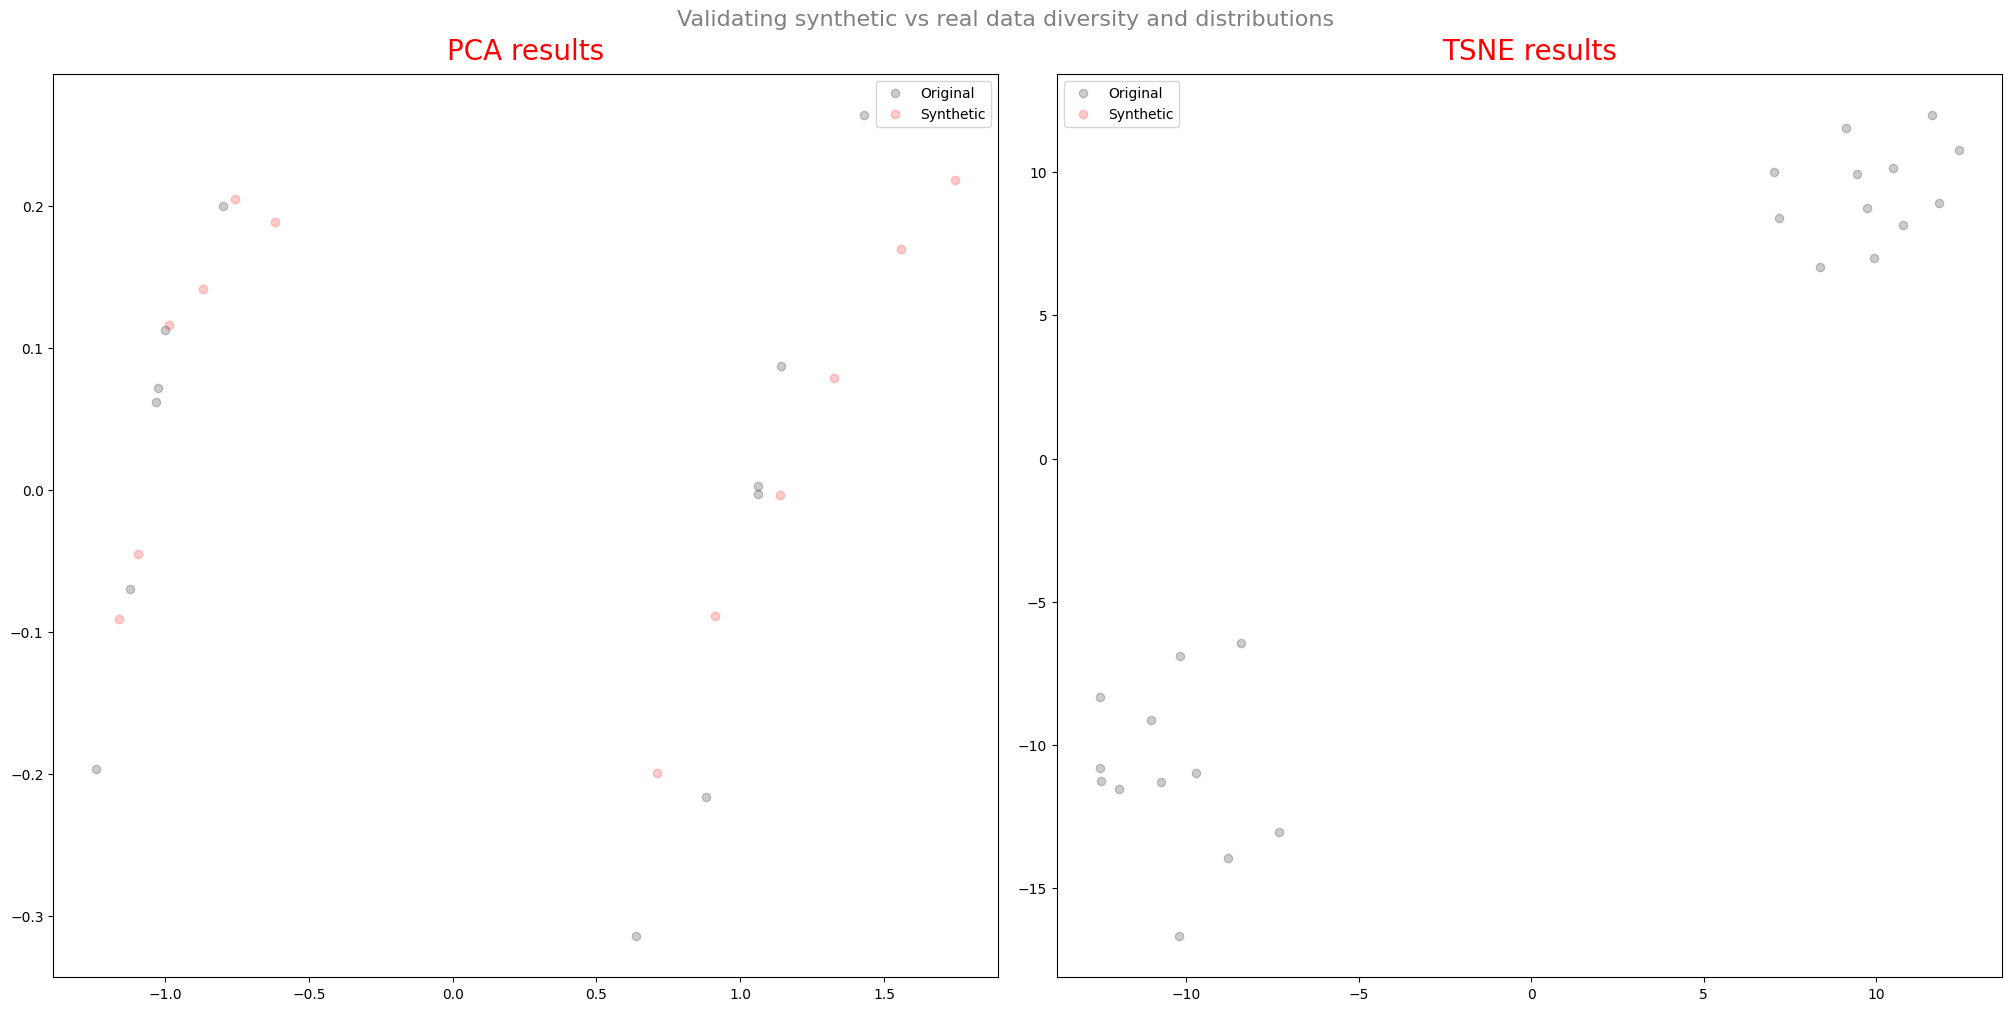

In [61]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# PCA scatter plot
ax = fig.add_subplot(spec[0, 0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

# TSNE scatter plot
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:, 0], tsne_results.iloc[sample_size:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

plt.show()

Visualisation finale

[[[0.90188324 0.94703364]
  [0.8341367  0.9442575 ]
  [0.8251852  0.7068418 ]
  [0.70755893 0.70841074]
  [0.6116852  0.79778236]
  [0.60783243 0.69837314]
  [0.53471756 0.6997342 ]
  [0.52070576 0.63990253]
  [0.47505164 0.5881244 ]
  [0.4445131  0.45653114]
  [0.4145576  0.33122793]
  [0.39107016 0.3012789 ]
  [0.34223902 0.24448326]
  [0.31106675 0.23231633]
  [0.30733708 0.21850514]
  [0.30657312 0.23646976]
  [0.29231948 0.27889434]
  [0.25560197 0.26528734]
  [0.21865892 0.27636176]
  [0.21606211 0.21966778]
  [0.21318929 0.23384643]
  [0.15920976 0.17097749]
  [0.09957726 0.02728234]
  [0.09291556 0.05433062]]

 [[0.8970189  0.9391813 ]
  [0.8204684  0.8660459 ]
  [0.7899838  0.85185194]
  [0.7486034  0.6545076 ]
  [0.6043699  0.775257  ]
  [0.59210277 0.7440924 ]
  [0.55757904 0.67391425]
  [0.50045687 0.6619365 ]
  [0.4823534  0.57391715]
  [0.44282502 0.46838388]
  [0.41482517 0.3391138 ]
  [0.39179212 0.305374  ]
  [0.34401923 0.24633986]
  [0.31181917 0.23139839]
  [0.30745

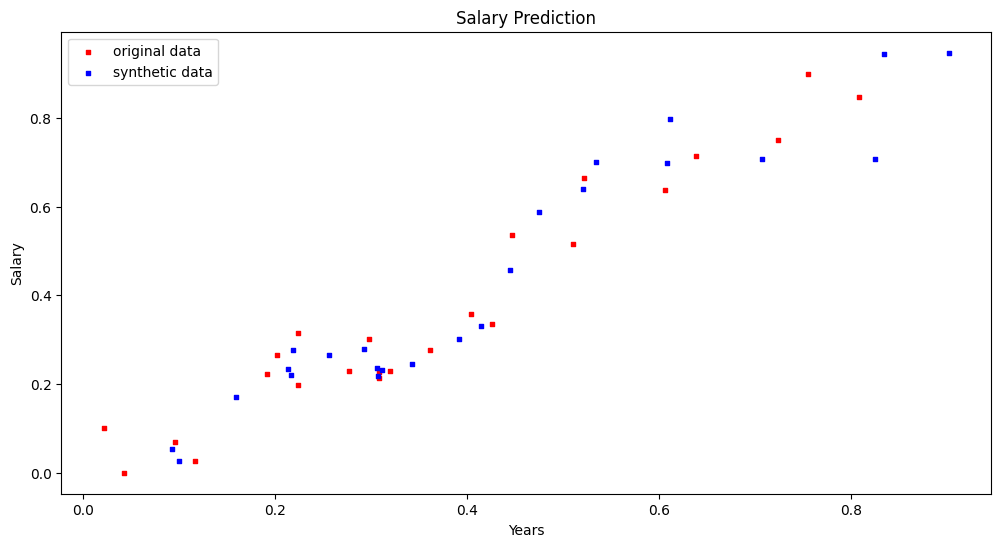

In [62]:
print(synthetic_sample)

_1 = np.array(real_sample[0])
_2 = np.array(synthetic_sample[0])

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(_1[:, 0], _1[:, 1], s=10, c='r', marker="s", label='original data')
ax1.scatter(_2[:, 0], _2[:, 1], s=10, c='b', marker="s", label='synthetic data')
plt.xlabel('Years')
plt.ylabel('Salary')
plt.title('Salary Prediction')
plt.legend(loc='upper left')

plt.show()

KDE Plot

/tmp/ipython-input-4241469014.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(_1[:, 0], shade=True, color="r", ax=ax1)
/tmp/ipython-input-4241469014.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(_2[:, 0], shade=True, color="b", ax=ax1)


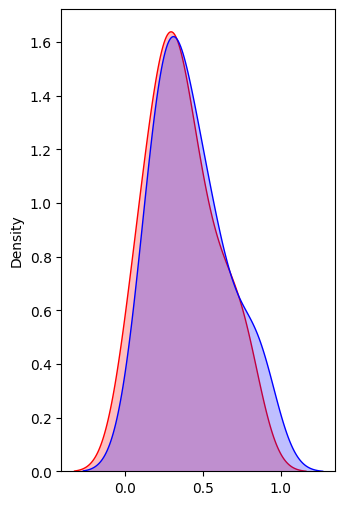

In [63]:
import seaborn as sns

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 3, 1)
sns.kdeplot(_1[:, 0], shade=True, color="r", ax=ax1)
sns.kdeplot(_2[:, 0], shade=True, color="b", ax=ax1)

plt.show()

Distribution des caractéristiques

/tmp/ipython-input-394456237.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array(real_sample)[:, :, 0].flatten(), ax=axes[1, 0], label='Real', color='blue', shade=True, alpha=0.5)
/tmp/ipython-input-394456237.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array(synthetic_sample)[:, :, 0].flatten(), ax=axes[1, 0], label='Synthetic', color='red', shade=True, alpha=0.5)
/tmp/ipython-input-394456237.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array(real_sample)[:, :, 1].flatten(), ax=axes[1, 1], label='Real', color='blue', shade=True, alpha=0.5)
/tmp/ipython-input-394456237.py:30: FutureWarning

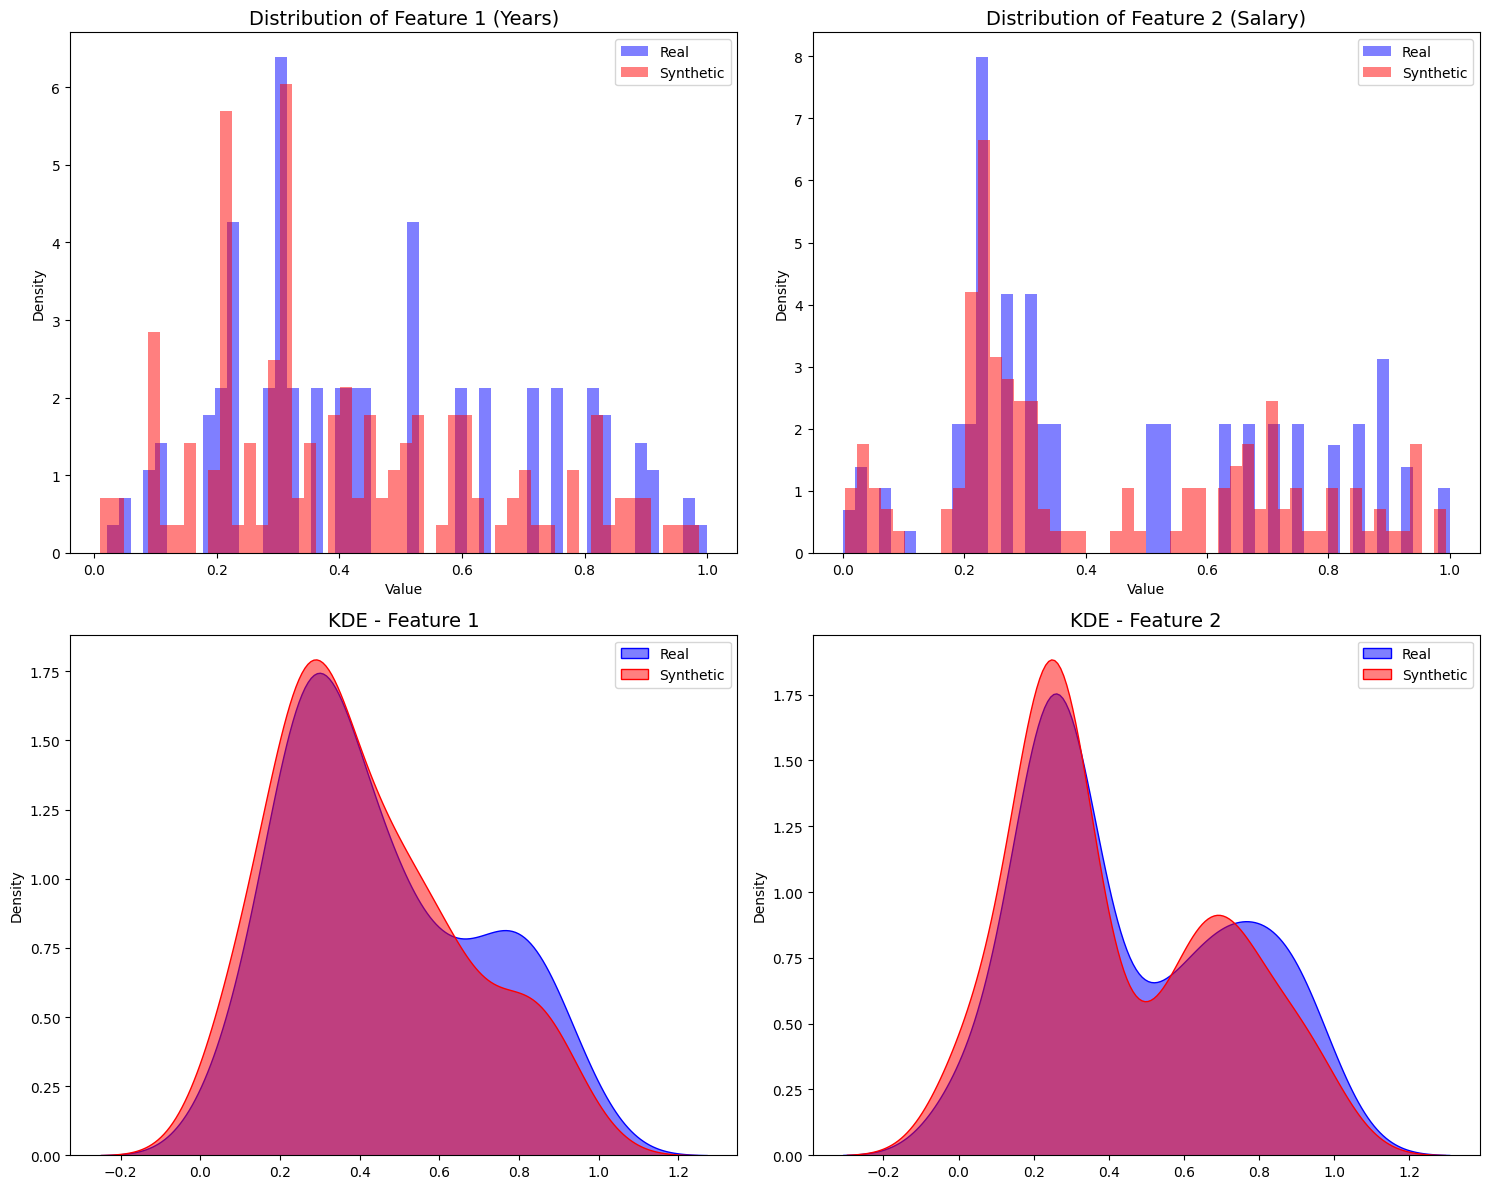

In [64]:
# Distribution des deux features
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Feature 1 - Distribution
axes[0, 0].hist(np.array(real_sample)[:, :, 0].flatten(), bins=50, alpha=0.5, label='Real', color='blue', density=True)
axes[0, 0].hist(np.array(synthetic_sample)[:, :, 0].flatten(), bins=50, alpha=0.5, label='Synthetic', color='red', density=True)
axes[0, 0].set_title('Distribution of Feature 1 (Years)', fontsize=14)
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

# Feature 2 - Distribution
axes[0, 1].hist(np.array(real_sample)[:, :, 1].flatten(), bins=50, alpha=0.5, label='Real', color='blue', density=True)
axes[0, 1].hist(np.array(synthetic_sample)[:, :, 1].flatten(), bins=50, alpha=0.5, label='Synthetic', color='red', density=True)
axes[0, 1].set_title('Distribution of Feature 2 (Salary)', fontsize=14)
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Feature 1 - KDE Plot
sns.kdeplot(np.array(real_sample)[:, :, 0].flatten(), ax=axes[1, 0], label='Real', color='blue', shade=True, alpha=0.5)
sns.kdeplot(np.array(synthetic_sample)[:, :, 0].flatten(), ax=axes[1, 0], label='Synthetic', color='red', shade=True, alpha=0.5)
axes[1, 0].set_title('KDE - Feature 1', fontsize=14)
axes[1, 0].legend()

# Feature 2 - KDE Plot
sns.kdeplot(np.array(real_sample)[:, :, 1].flatten(), ax=axes[1, 1], label='Real', color='blue', shade=True, alpha=0.5)
sns.kdeplot(np.array(synthetic_sample)[:, :, 1].flatten(), ax=axes[1, 1], label='Synthetic', color='red', shade=True, alpha=0.5)
axes[1, 1].set_title('KDE - Feature 2', fontsize=14)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

Corrélation entre features

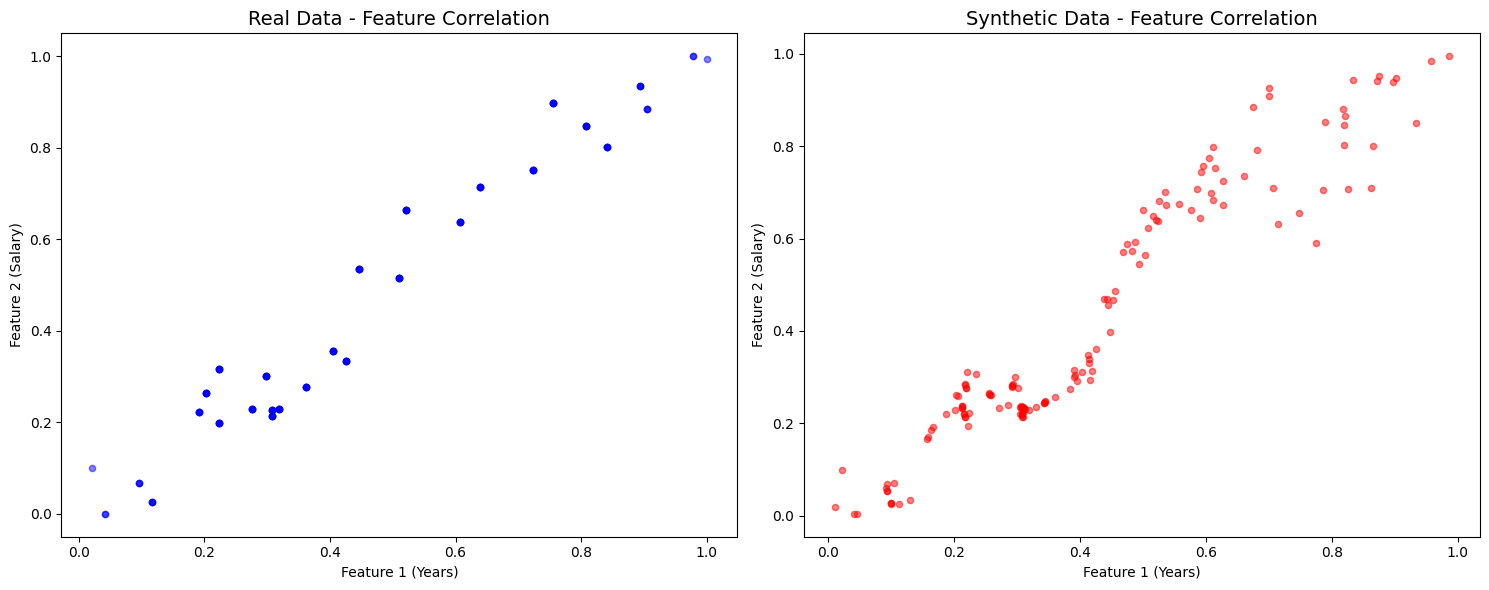

Real data correlation: 0.9687
Synthetic data correlation: 0.9522


In [65]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

real_flat = np.array(real_sample).reshape(-1, 2)
axes[0].scatter(real_flat[:, 0], real_flat[:, 1], alpha=0.5, c='blue', s=20)
axes[0].set_title('Real Data - Feature Correlation', fontsize=14)
axes[0].set_xlabel('Feature 1 (Years)')
axes[0].set_ylabel('Feature 2 (Salary)')

synth_flat = np.array(synthetic_sample).reshape(-1, 2)
axes[1].scatter(synth_flat[:, 0], synth_flat[:, 1], alpha=0.5, c='red', s=20)
axes[1].set_title('Synthetic Data - Feature Correlation', fontsize=14)
axes[1].set_xlabel('Feature 1 (Years)')
axes[1].set_ylabel('Feature 2 (Salary)')

plt.tight_layout()
plt.show()

print(f"Real data correlation: {np.corrcoef(real_flat.T)[0, 1]:.4f}")
print(f"Synthetic data correlation: {np.corrcoef(synth_flat.T)[0, 1]:.4f}")

Séries temporelles individuelles

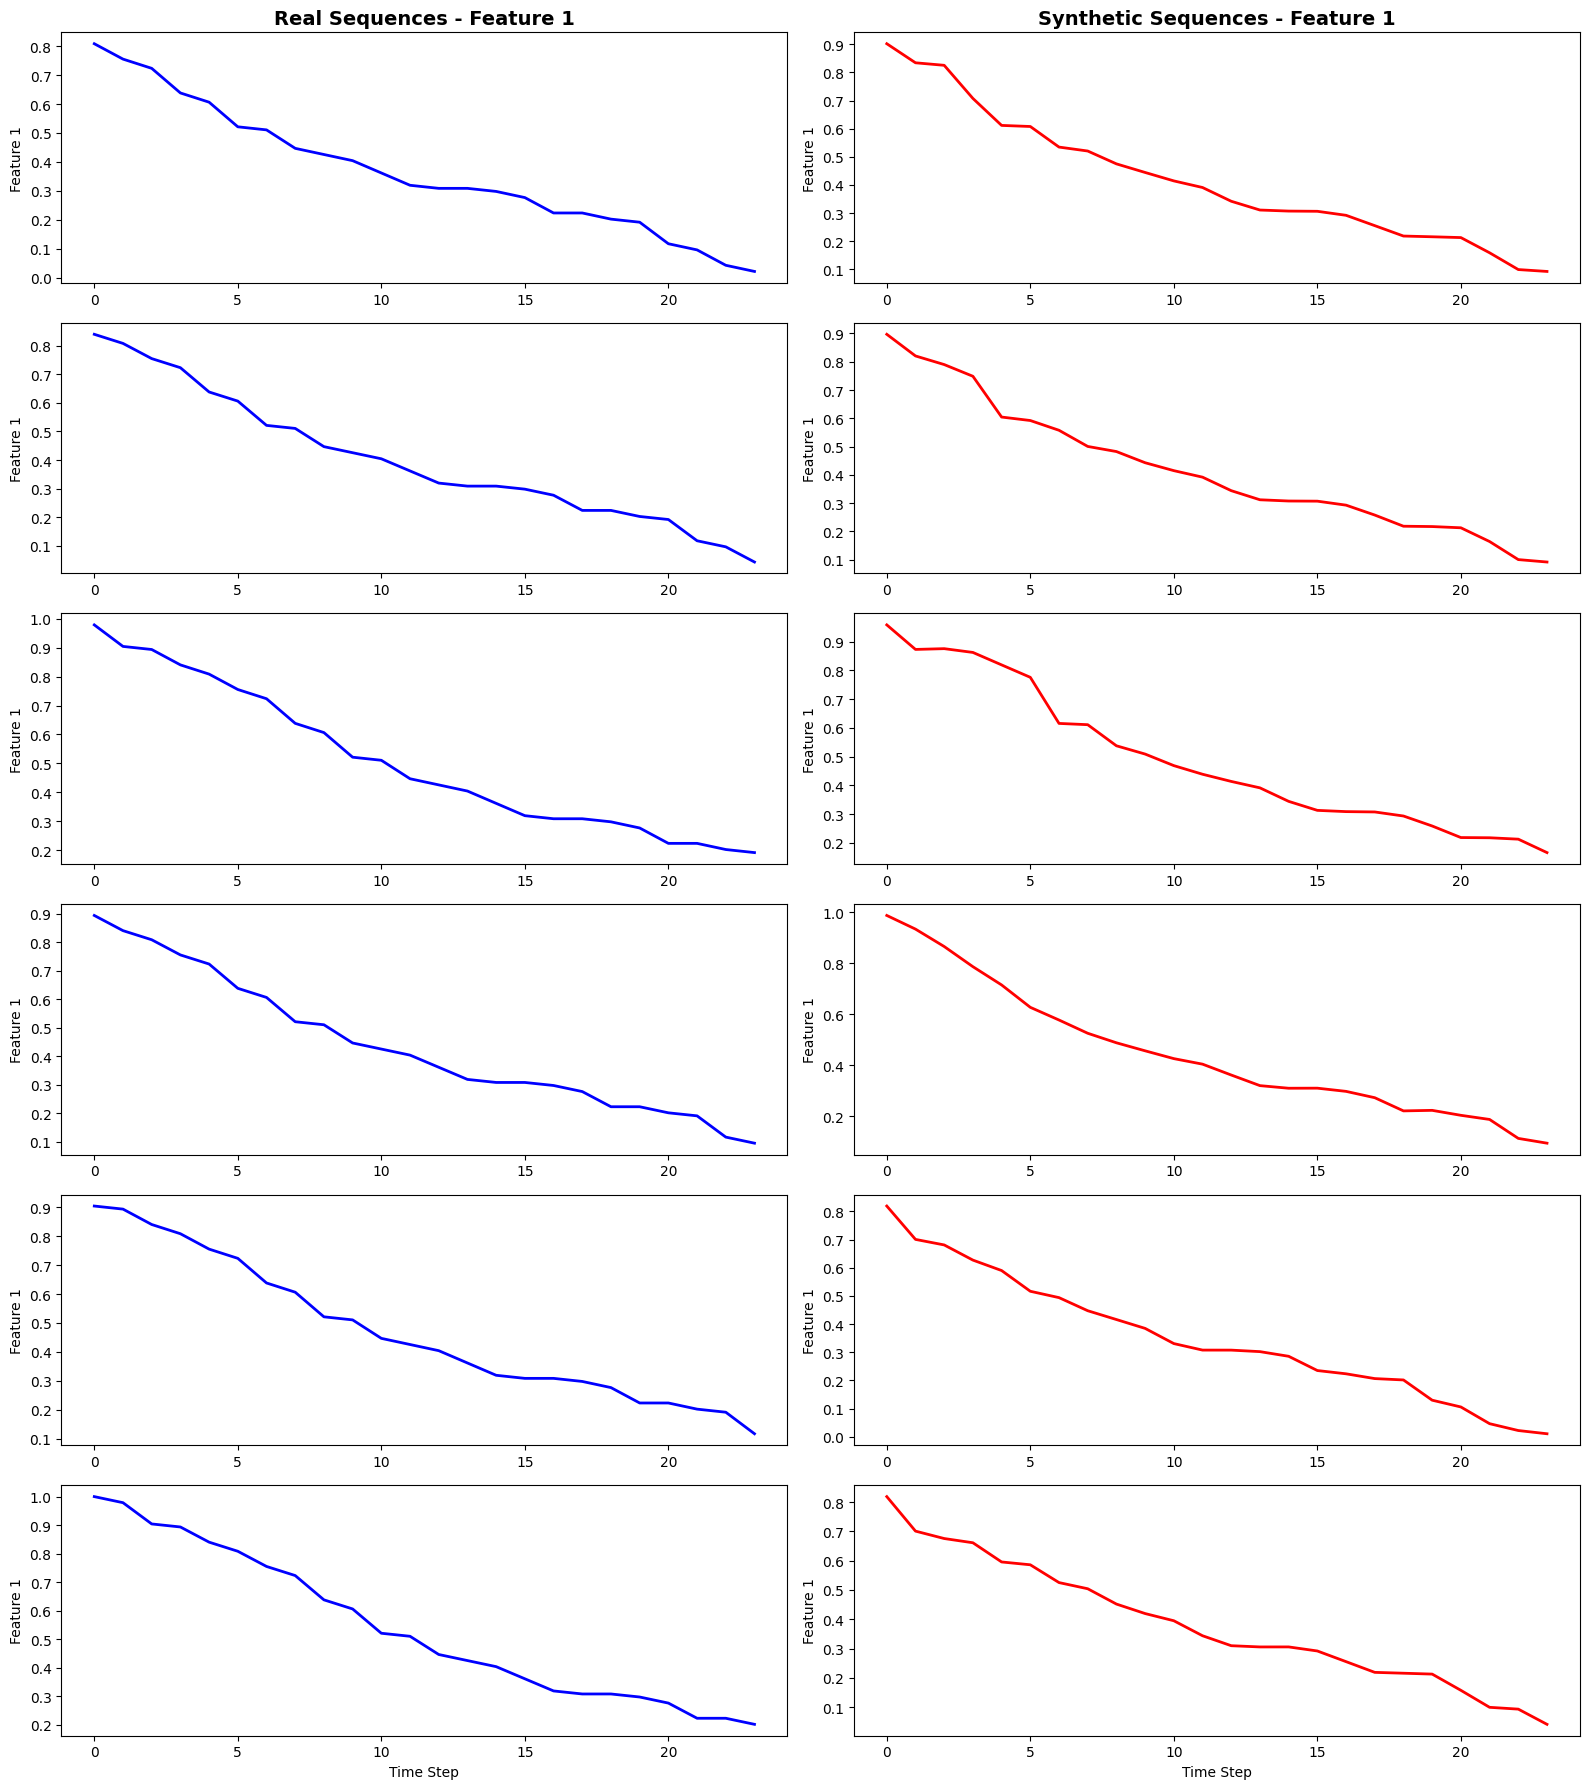

In [66]:
# Compare individual sequences
n_samples_to_plot = 6
fig, axes = plt.subplots(n_samples_to_plot, 2, figsize=(16, 3*n_samples_to_plot))

for i in range(n_samples_to_plot):
    # Real sequence - Feature 1
    axes[i, 0].plot(real_sample[i][:, 0], 'b-', label='Years', linewidth=2)
    axes[i, 0].set_ylabel('Feature 1', fontsize=10)
    if i == 0:
        axes[i, 0].set_title('Real Sequences - Feature 1', fontsize=14, fontweight='bold')
    if i == n_samples_to_plot - 1:
        axes[i, 0].set_xlabel('Time Step', fontsize=10)

    # Synthetic sequence - Feature 1
    axes[i, 1].plot(synthetic_sample[i][:, 0], 'r-', label='Years', linewidth=2)
    axes[i, 1].set_ylabel('Feature 1', fontsize=10)
    if i == 0:
        axes[i, 1].set_title('Synthetic Sequences - Feature 1', fontsize=14, fontweight='bold')
    if i == n_samples_to_plot - 1:
        axes[i, 1].set_xlabel('Time Step', fontsize=10)

plt.tight_layout()
plt.show()

Statistiques comparatives

In [67]:
real_data_flat = np.array(real_sample).reshape(-1, 2)
synth_data_flat = np.array(synthetic_sample).reshape(-1, 2)

stats_comparison = pd.DataFrame({
    'Metric': ['Mean F1', 'Std F1', 'Min F1', 'Max F1', 'Mean F2', 'Std F2', 'Min F2', 'Max F2'],
    'Real Data': [
        real_data_flat[:, 0].mean(), real_data_flat[:, 0].std(),
        real_data_flat[:, 0].min(), real_data_flat[:, 0].max(),
        real_data_flat[:, 1].mean(), real_data_flat[:, 1].std(),
        real_data_flat[:, 1].min(), real_data_flat[:, 1].max()
    ],
    'Synthetic Data': [
        synth_data_flat[:, 0].mean(), synth_data_flat[:, 0].std(),
        synth_data_flat[:, 0].min(), synth_data_flat[:, 0].max(),
        synth_data_flat[:, 1].mean(), synth_data_flat[:, 1].std(),
        synth_data_flat[:, 1].min(), synth_data_flat[:, 1].max()
    ]
})

stats_comparison['Difference'] = np.abs(stats_comparison['Real Data'] - stats_comparison['Synthetic Data'])
stats_comparison['Relative Diff (%)'] = (stats_comparison['Difference'] / stats_comparison['Real Data'] * 100).round(2)

print("\n" + "="*80)
print("STATISTICAL COMPARISON")
print("="*80)
print(stats_comparison.to_string(index=False))
print("="*80)


STATISTICAL COMPARISON
 Metric  Real Data  Synthetic Data  Difference  Relative Diff (%)
Mean F1   0.454418        0.418104    0.036314               7.99
 Std F1   0.244355        0.234238    0.010117               4.14
 Min F1   0.021277        0.010283    0.010994              51.67
 Max F1   1.000000        0.986756    0.013244               1.32
Mean F2   0.458199        0.422561    0.035638               7.78
 Std F2   0.276379        0.270929    0.005451               1.97
 Min F2   0.000000        0.003913    0.003913                inf
 Max F2   1.000000        0.994768    0.005232               0.52


Box plots comparatifs

/tmp/ipython-input-3714258433.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(data_f1, labels=['Real', 'Synthetic'], patch_artist=True)
/tmp/ipython-input-3714258433.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(data_f2, labels=['Real', 'Synthetic'], patch_artist=True)


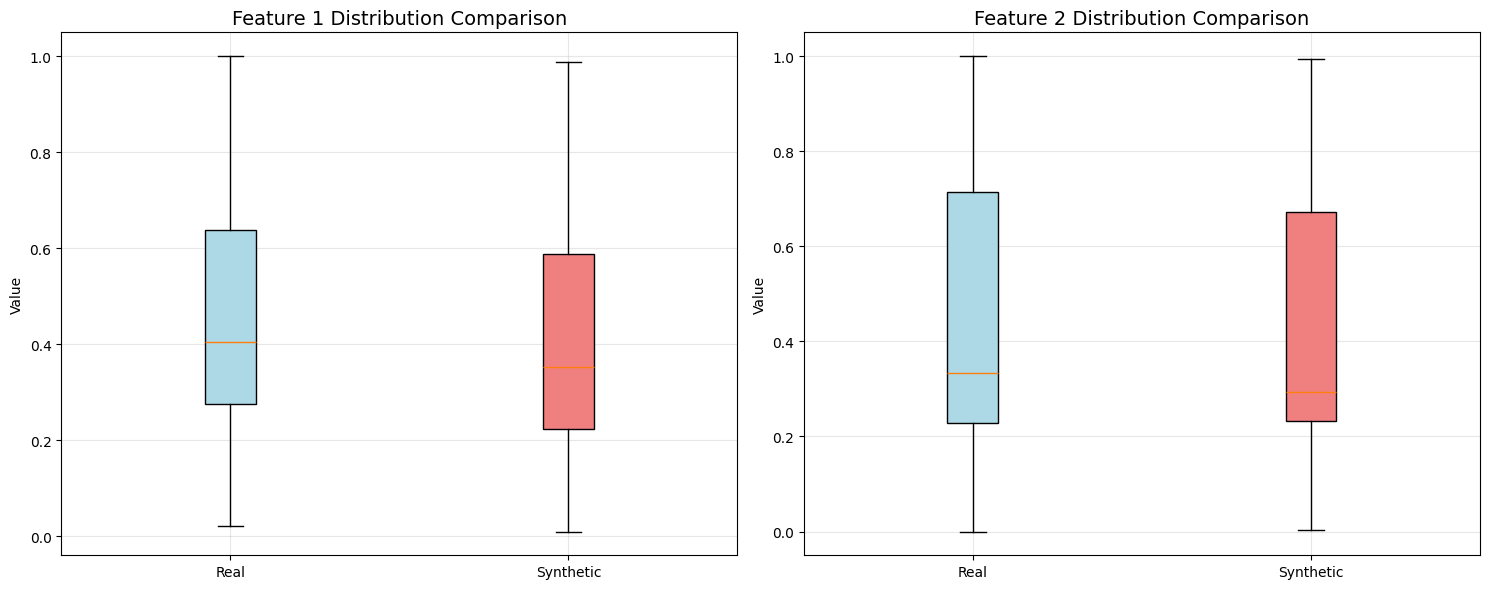

In [68]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Feature 1
data_f1 = [real_data_flat[:, 0], synth_data_flat[:, 0]]
bp1 = axes[0].boxplot(data_f1, labels=['Real', 'Synthetic'], patch_artist=True)
bp1['boxes'][0].set_facecolor('lightblue')
bp1['boxes'][1].set_facecolor('lightcoral')
axes[0].set_title('Feature 1 Distribution Comparison', fontsize=14)
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)

# Feature 2
data_f2 = [real_data_flat[:, 1], synth_data_flat[:, 1]]
bp2 = axes[1].boxplot(data_f2, labels=['Real', 'Synthetic'], patch_artist=True)
bp2['boxes'][0].set_facecolor('lightblue')
bp2['boxes'][1].set_facecolor('lightcoral')
axes[1].set_title('Feature 2 Distribution Comparison', fontsize=14)
axes[1].set_ylabel('Value')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Heatmap de corrélation temporelle

Visualisation 3D

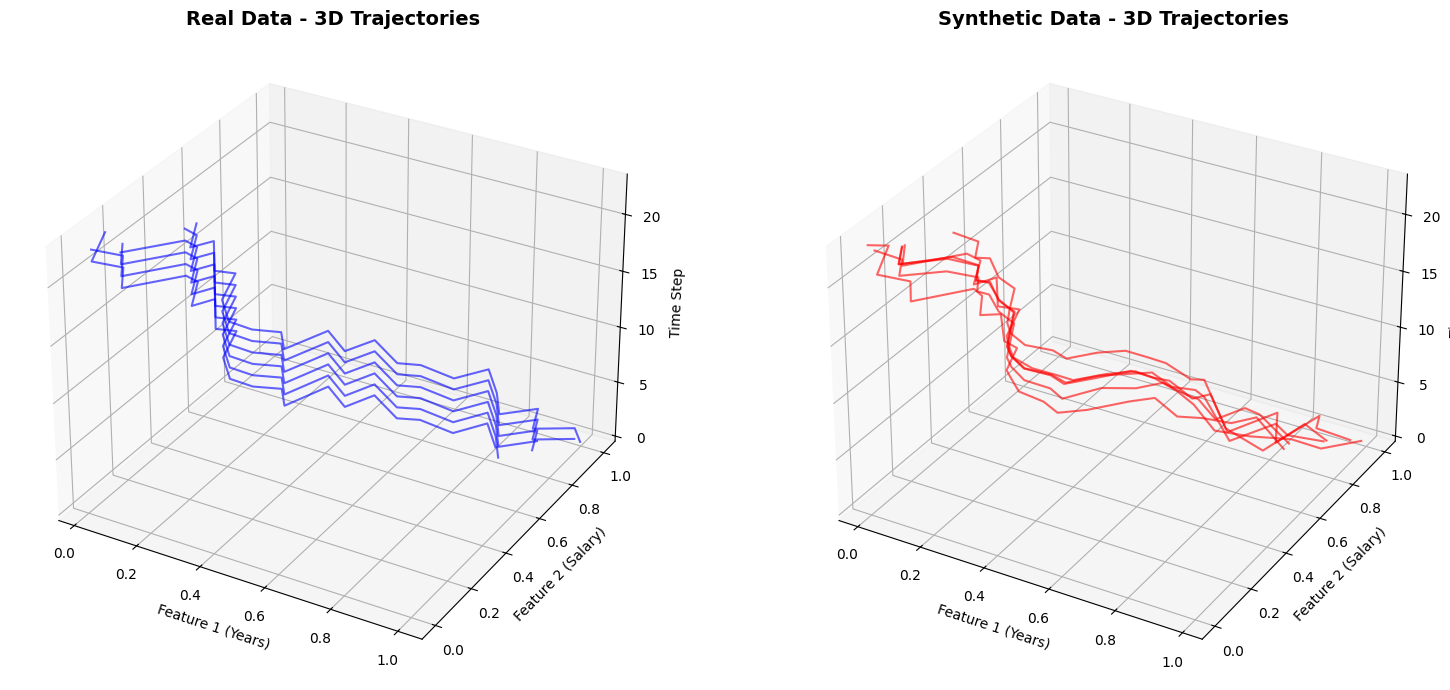

In [70]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 7))

# Real data
ax1 = fig.add_subplot(121, projection='3d')
for i in range(min(10, len(real_sample))):
    ax1.plot(real_sample[i][:, 0], real_sample[i][:, 1],
             range(len(real_sample[i])), 'b-', alpha=0.6, linewidth=1.5)
ax1.set_xlabel('Feature 1 (Years)', fontsize=10)
ax1.set_ylabel('Feature 2 (Salary)', fontsize=10)
ax1.set_zlabel('Time Step', fontsize=10)
ax1.set_title('Real Data - 3D Trajectories', fontsize=14, fontweight='bold')

# Synthetic data
ax2 = fig.add_subplot(122, projection='3d')
for i in range(min(10, len(synthetic_sample))):
    ax2.plot(synthetic_sample[i][:, 0], synthetic_sample[i][:, 1],
             range(len(synthetic_sample[i])), 'r-', alpha=0.6, linewidth=1.5)
ax2.set_xlabel('Feature 1 (Years)', fontsize=10)
ax2.set_ylabel('Feature 2 (Salary)', fontsize=10)
ax2.set_zlabel('Time Step', fontsize=10)
ax2.set_title('Synthetic Data - 3D Trajectories', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()